In [46]:
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version


nu
[  0.47317561   0.47364167   0.47410864 ... 236.37079595 236.50620759
 236.64158153]
Tsig
[ 0.00000000e+00 -8.56770291e-09 -8.51986238e-09 ...  2.65184016e-03
  2.64729438e-03  2.64276187e-03]
[ 0.47317561  0.47364167  0.47410864 ... 49.79705315 49.85427452
 49.96878272]
[ 0.00000000e+00 -8.56770291e-09 -8.51986238e-09 ... -1.32996469e-02
 -1.34936707e-02 -1.38915877e-02]
1486
[-8.79159443e-09 -9.37194041e-09 -1.00415801e-08 ... -1.08299577e-02
 -1.08802894e-02 -1.09316285e-02]
2500
[-8.79159443e-06 -9.37194041e-06 -1.00415801e-05 ... -1.08299577e+01
 -1.08802894e+01 -1.09316285e+01]


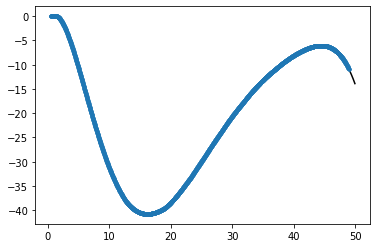

In [47]:
data = load("signal.npz")
lst = data.files
for item in lst:
    print(item)
    print(data[item])

nu = data['nu']
nu_50 = nu[nu<50]
nu6 = nu_50*1E6

Tsig = data['Tsig']
Tsig_50 = Tsig[nu<50]        # unit of k
Tsig3 = Tsig_50*1E3      # unit of mk

plt.plot(nu_50,Tsig3,'k')
length = len(nu_50)
print(nu_50)
print(Tsig_50)
print(len(nu_50))
#interpolate linear and cubic
nu_50_new = np.linspace(0.48,49,2500)
Tsig_50_new = interp1d(nu_50,Tsig3)
plt.plot(nu_50_new,Tsig_50_new(nu_50_new),'.')

nu6 = nu_50_new*1E6
nu_50 = nu_50_new
Tsign3 = Tsig_50_new(nu_50_new)      #unit of mk
Tsig_50 = Tsign3*1E-3 #unit of k
print(Tsig_50)
print(len(Tsig_50))
print(Tsign3)

In [48]:
nu0 = 20E6 #hz
def func(x,a,b):
    return (40000+a)*(x/nu0)**(-2.5+b)             #without pre weighting with nu^(-2.5)
def func2(x,a,b,Amp):
    return (((40000+a)*(x/nu0)**(-2.5+b))+Amp)/((40000)*(x/nu0)**(-2.5))    #with pre weighting with nu^(-2.5)

In [49]:
T2 = func(nu6,0,0)     #T2 is the foreground from trivial power law    #units of k
weight = (40000)*(nu6/nu0)**(-2.5)
Tdata = (T2 + Tsig_50)    #units of k
T_wdata = (T2 + Tsig_50)/ weight                 # T_wdata is foreground + signal, and scaled by nu6^(-2.5)
#print(weight)
#print(Tdata)
#plt.plot(nu_50,T_wdata,'b-',label = 'data')
#print(np.mean(T2))

[4.48261961e+08 4.05956368e+08 3.69036288e+08 ... 4.26583883e+03
 4.26161261e+03 4.25739225e+03]
[  980221.35799985   839683.83989826   399010.44262592 ...
   -88623.56688549  -537017.5758813  -1183496.57538054]


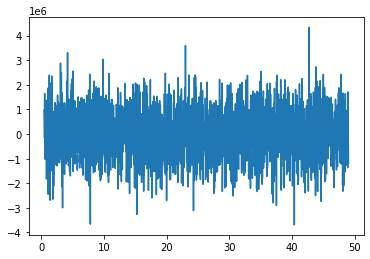

In [50]:
# Power calculation for noise.

Power = sum(Tdata**2)/len(Tsig_50)
SNR = 1E6            #I'm not sure if I can take this,  but the reason I chose this so that noise doesn't get to 
                               # values to the signal at higher frequencies
Power_noise = Power/SNR
mean_noise = 0
#noise = np.random.normal(mean_noise,np.sqrt(Power_noise),len(Tsig_50))
noise = np.random.normal(mean_noise,SNR,len(Tsig_50))
plt.plot(nu_50,noise)
#plt.xlim(10,50)
#plt.ylim(-1,1)
print(Tdata)
print(noise)
##print(len(Tdata))
#print(len(nu_50))

## The noise above behaves in weird fashion near the expected signal frequency.

In [51]:
T_wndata = (Tdata + noise)/weight #T_wndata is weighted data with noise
print(T_wndata)

[   1.00218672    1.00206841    1.00108122 ...  -19.77512915 -125.01244282
 -276.98555498]


In [52]:
popt,pcov = curve_fit(func2,nu6,T_wndata)             #curve-fitting done with the scaling of nu6^(-2.5)
popt

array([ 5.04874022e+04,  2.59815733e+00, -7.03421885e+04])

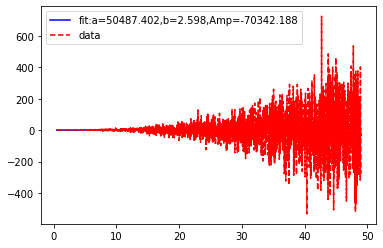

In [53]:
plt.plot(nu_50,func2(nu6,*popt),'b-',label = 'fit:a=%5.3f,b=%5.3f,Amp=%5.3f' %tuple(popt))
plt.plot(nu_50,T_wndata,'r--',label = 'data')
plt.legend() #with weighting (foreground+signal+noise)

## Is this a lot of noise?

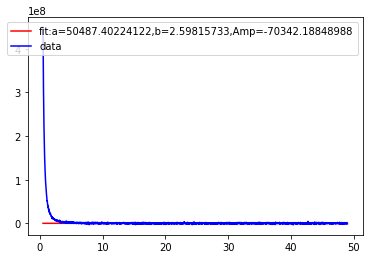

In [58]:
plt.plot(nu_50,func2(nu6,*popt)*weight,'r-',label = 'fit:a=%10.8f,b=%10.8f,Amp=%10.8f' %tuple(popt))
plt.plot(nu_50,T_wndata*weight,'b-',label = 'data')
plt.legend()  #without weighting (foreground + signal+noise)


# The green line has a lot of noise. So, there's a need to analyse using different method.

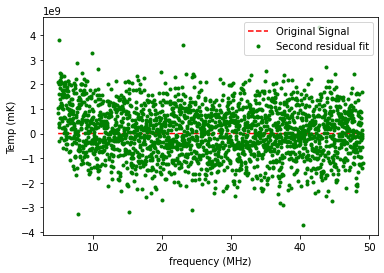

In [59]:
fit = func2(nu6,*popt)*weight
Tsig_fit = -1*(fit - T2)*1e3
Tsig_fit2 = (T_wndata*weight - fit)*1e3
#plt.plot(nu_50,Tsig_fit,'b-',label='from fit')
plt.plot(nu_50[nu_50>5],Tsign3[nu_50>5],'r--',label = 'Original Signal')
plt.plot(nu_50[nu_50>5],Tsig_fit2[nu_50>5],'g.',label = 'Second residual fit')
plt.xlabel("frequency (MHz)")
plt.ylabel("Temp (mK)")
plt.legend()
#plt.ylim(-100,50)  #original signal vs signal from fitting

## Noise dominating the original signal.


## Tophat and Gaussian

In [62]:
#bins = np.arange(0,50,0.0001)
#Tophat = 

[0.00000e+00 1.00000e-04 2.00000e-04 ... 4.99997e+01 4.99998e+01
 4.99999e+01]
[ 0.48        0.49941577  0.51883153 ... 48.96116847 48.98058423
 49.        ]
